In this notebook, I explore some of the S2 rasters, see how to mask them out based on the classification band and how to merge them monthly into medians and maybe how to interpolate some of the missing values

In [8]:
import rasterio
from rasterio.plot import show
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
%matplotlib inline

In [10]:
# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

Normalized bands
0.0 - 1.0 mean: 0.0570226440021899
0.0 - 1.0 mean: 0.06959920561619219
0.0 - 1.0 mean: 0.0457738969323509


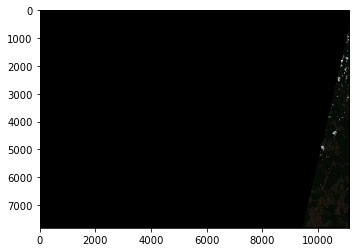

In [11]:
# As per https://automating-gis-processes.github.io/site/notebooks/Raster/plotting-raster.html 


path = '../data/aoi_1/raster/2019/01Sep2019.tif'


with rasterio.open(path) as src:

    # Read the grid values into numpy arrays
    red = src.read(3)
    green = src.read(2)
    blue = src.read(1)


    red = np.ma.array(red, mask=np.isnan(red))
    green = np.ma.array(green, mask=np.isnan(green))
    blue = np.ma.array(blue, mask=np.isnan(blue))

    # Normalize the bands
    redn = normalize(red)
    greenn = normalize(green)
    bluen = normalize(blue)

    print("Normalized bands")
    print(redn.min(), '-', redn.max(), 'mean:', redn.mean())
    print(greenn.min(), '-', greenn.max(), 'mean:', greenn.mean())
    print(bluen.min(), '-', bluen.max(), 'mean:', bluen.mean())

    # Create RGB natural color composite
    rgb = np.dstack((redn, greenn, bluen))

    # Let's see how our color composite looks like
    plt.imshow(rgb)

In [10]:
path = '../data/aoi_1/raster/2019/01Sep2019.tif'


with rasterio.open(path) as src:

    data = src.read()
    profile = src.profile
    


In [99]:
s2_scl_table = {
    1 : "satured or defective",
    2 : "dark area pixels",
    3 : "cloud shadows",
    4 : "vegetation",
    5 : "bare soils",
    6 : "water",
    7 : "clouds low probability/unclassified",
    8 : "clouds medium probability",
    9 : "clouds high probability",
    10 : "cirrus",
    11 : "snow/ice"
}


# I create a 2D mask that returns false for pixels where the classification isn't nan and also isn't one of the undesired values (clouds, shadows,..)
#mask = ~(np.isin(data[-1], [1,3,7,8,9]) | np.isnan(data[-1]))



array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [14]:
image = data[:3]
image_valid = np.ma.array(image, mask=np.isnan(image))
print(image.shape, image.mean())
print(image_valid.shape, image_valid.max())

(3, 7818, 11132) nan
(3, 7818, 11132) 8576.0


In [15]:
mask_2d = ~np.isin(data[-1], [1,3,7,8,9])
mask_3d = np.broadcast_to(mask_2d, image_valid.shape)

In [21]:
image_valid[~mask_3d] = np.nan

In [26]:
profile.update(count=3)
with rasterio.open('1sep_masked.tif', "w", **profile) as sink:
    sink.write(image_valid)

So far, things worked. I get a raster with masked out nondata + shadow/cloud values. The cloud masking is not perfect. Perhaps I should add some buffer at a later stage (although not sure how atm)

Let's now merge multiple rasters from 1 month into a median of them.

In [38]:
#np.nanmedian(a, axis=None, out=None,
#Compute the median along the specified axis, while ignoring NaNs

import glob
month = 'Sep'
rasters = glob.glob(f'../data/aoi_1/raster/2019/*{month}*')

In [5]:
def mask_raster(path):

    with rasterio.open(path) as src:

        data = src.read()
        profile = src.profile

    image = data[:3]
    image_valid = np.ma.array(image, mask=np.isnan(image))


    mask_2d = ~np.isin(data[-1], [1,3,7,8,9])
    mask_3d = np.broadcast_to(mask_2d, image_valid.shape)

    image_valid[~mask_3d] = np.nan

    return image_valid



In [39]:
masked_rasters = [mask_raster(path) for path in rasters]

In [45]:
print([np.ma.array(image, mask=np.isnan(image)).mean() for image in masked_rasters])

[536.9061120761932, 1158.046731488407, 397.2447595594308, 529.4294642407534, 663.3485779806065, 603.1388458112933, 596.6382554087584]


In [42]:
stacked = np.stack(masked_rasters)
stacked.shape



(7, 3, 7818, 11132)

In [43]:
out = np.nanmedian(stacked, axis=0)

/home/jan/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [46]:
profile.update(count=3)
with rasterio.open('../data/workdir/sep_mosaic.tif', "w", **profile) as sink:
    sink.write(out)

In [48]:
out_mean = np.nanmean(stacked, axis=0)
profile.update(count=3)
with rasterio.open('../data/workdir/sep_mean.tif', "w", **profile) as sink:
    sink.write(out_mean)

/tmp/ipykernel_860226/1421056936.py:1: RuntimeWarning: Mean of empty slice
  out_mean = np.nanmean(stacked, axis=0)


In [12]:
def write_monthly_median(month):
    files = glob.glob(f'../data/aoi_1/raster/2019/*{month}*')
    if len(files) < 2:
        return

    masked_rasters = [mask_raster(path) for path in files]
    stacked = np.stack(masked_rasters)
    out = np.nanmedian(stacked, axis=0)
    profile.update(count=3)
    with rasterio.open(f'../data/workdir/monthly_medians/{month}.tif', "w", **profile) as sink:
        sink.write(out)

 


In [ ]:
for month in ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]:
    write_monthly_median(month)


